In [796]:
import pandas as pd;
import seaborn as sns;
import matplotlib.pyplot as plt;
from sklearn.neighbors import KNeighborsClassifier
import requests

In [797]:
# Configurações iniciais para plotagem dos gráficos:
sns.set_style("white");
plt.figure(figsize=(10, 10));

<Figure size 1000x1000 with 0 Axes>

In [798]:
# Lendo arquivo CSV:
data = pd.read_csv('diabetes_dataset.csv');

In [799]:
# Informações Gerais do dataframe (Colunas, tipo, etc):
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               572 non-null    int64  
 1   Glucose                   567 non-null    float64
 2   BloodPressure             537 non-null    float64
 3   SkinThickness             345 non-null    float64
 4   Insulin                   198 non-null    float64
 5   BMI                       561 non-null    float64
 6   DiabetesPedigreeFunction  572 non-null    float64
 7   Age                       572 non-null    int64  
 8   Outcome                   572 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 40.3 KB


In [800]:
# Quantidade de informações vazias para cada coluna
emptyColumns = data.isnull().sum();
print(emptyColumns);

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [801]:
# Count, média, desvio padrão, mínimo 
print(data.describe());

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   572.000000  567.000000     537.000000     345.000000  198.000000   
mean      4.106643  121.647266      73.150838      29.356522  156.934343   
std       3.446995   30.132084      12.347184      10.433503  119.066934   
min       0.000000   44.000000      30.000000       7.000000   16.000000   
25%       1.000000  100.000000      65.000000      22.000000   77.500000   
50%       3.000000  117.000000      72.000000      30.000000  129.500000   
75%       6.000000  140.000000      80.000000      36.000000  185.000000   
max      17.000000  199.000000     122.000000      99.000000  744.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  561.000000                572.000000  572.000000  572.000000  
mean    32.327629                  0.459121   34.043706    0.358392  
std      6.735437                  0.336124   12.103893    0.479948  
min     18.200000                  

In [802]:
# Removendo linhas onde a coluna possui dados vazios
def dropRows(data, columnName):
  data.dropna(subset=[columnName], inplace=True);

dropRows(data, 'Glucose');
dropRows(data, 'BMI');

emptyColumns = data.isnull().sum();
print(emptyColumns);

Pregnancies                   0
Glucose                       0
BloodPressure                28
SkinThickness               218
Insulin                     360
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


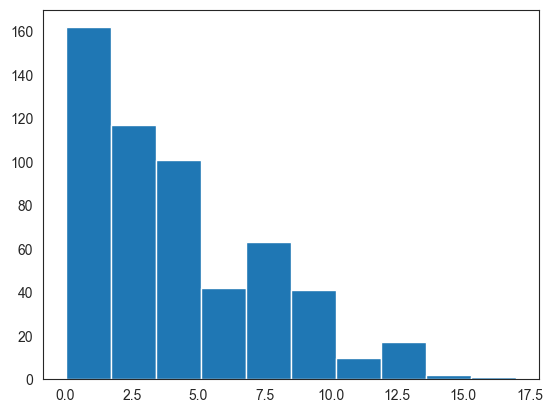

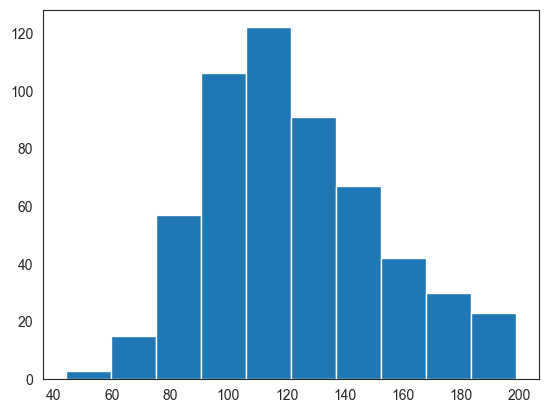

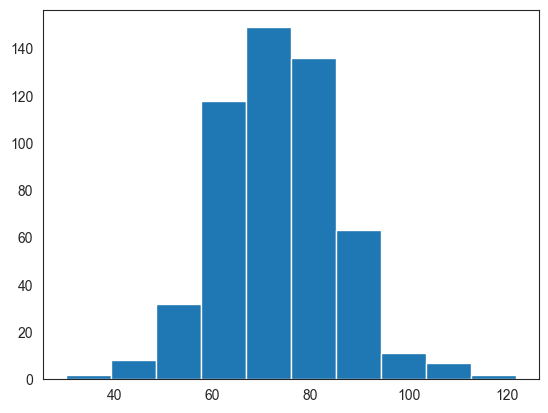

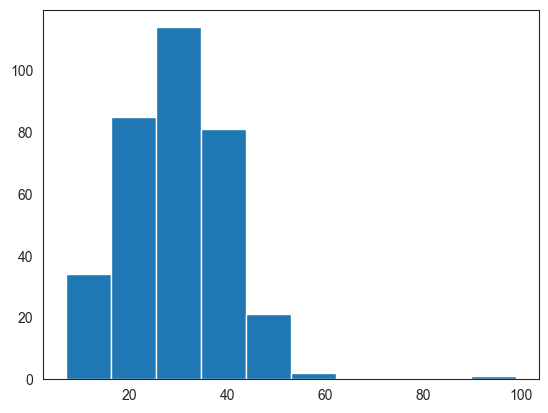

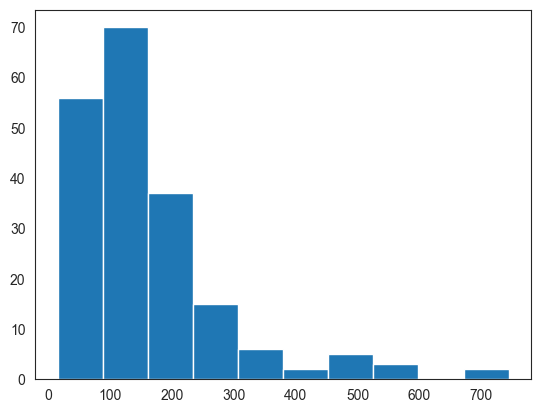

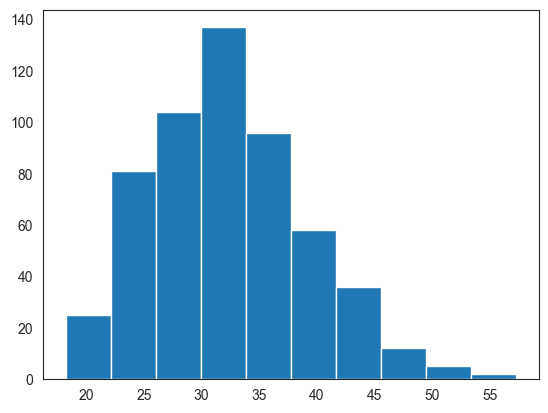

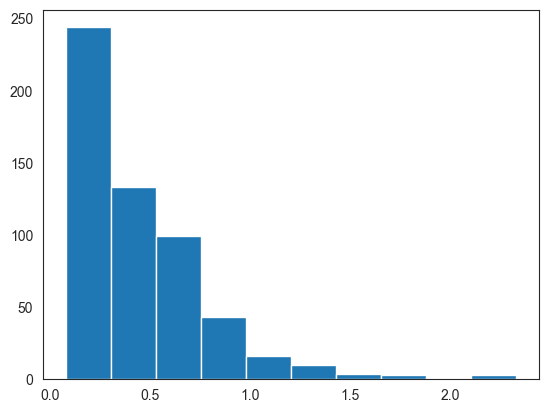

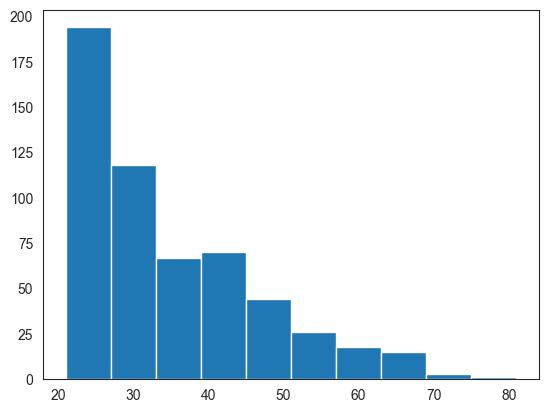

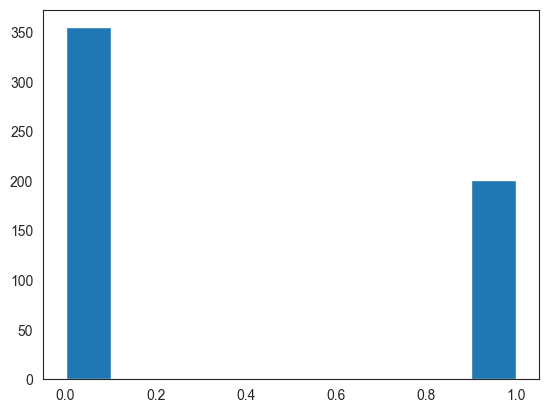

In [803]:
# Histograma:
def plotHistChart(dataFrame):
  plt.hist(x = dataFrame);
  plt.show();

plotHistChart(data['Pregnancies']);
plotHistChart(data['Glucose']);
plotHistChart(data['BloodPressure']);
plotHistChart(data['SkinThickness']);
plotHistChart(data['Insulin']);
plotHistChart(data['BMI']);
plotHistChart(data['DiabetesPedigreeFunction']);
plotHistChart(data['Age']);
plotHistChart(data['Outcome']);

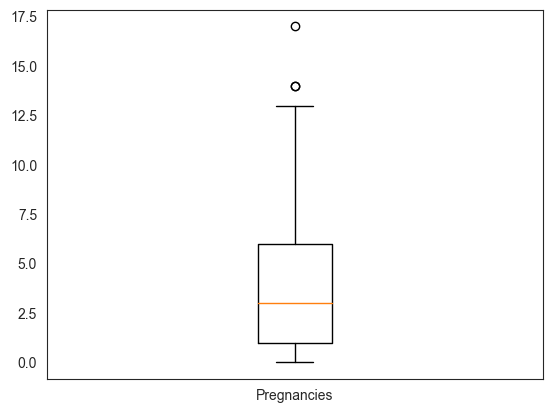

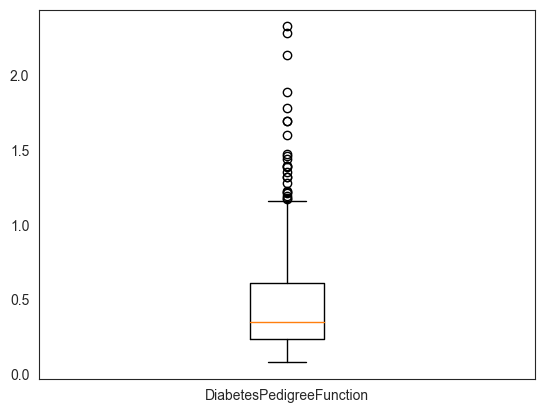

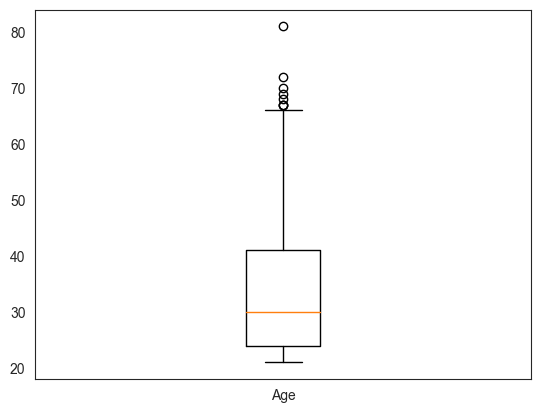

In [804]:
# Plotar gráfico boxplot:
def plotBoxPlot(dataFrame, label):
  plt.boxplot(dataFrame, vert=True, labels=label);
  plt.show();

plotBoxPlot(data['Pregnancies'], ['Pregnancies']);
plotBoxPlot(data['DiabetesPedigreeFunction'], ['DiabetesPedigreeFunction']);
plotBoxPlot(data['Age'], ['Age']);

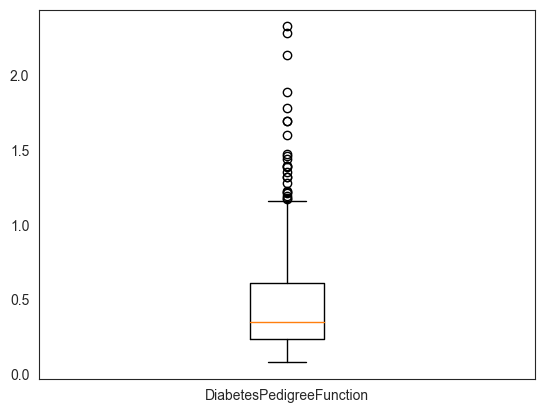

In [805]:
# Referência: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
# Analisando o boxPlot acima (DiabetesPedigreeFunction), 
# conseguimos ver que há muitos outliers acima do limite superior;

# Removendo os outliers:
def dropOutliers(data, columnName):
  percentile25, percentile75 = np.percentile(data[columnName], [25, 75]);
  # IQR = Q3 − Q1 (intervalo interquartil).
  iqr = percentile75 - percentile25;
  print(iqr);

  lower = percentile25 - (1.5 * iqr);
  upper = percentile75 + (1.5 * iqr);

  dataWithoutOutliers = data[
    (data[columnName] >= lower) &
    (data[columnName] <= upper)
  ];

  return dataWithoutOutliers;

# dataWithoutOutliers = dropOutliers(data, 'DiabetesPedigreeFunction');
dataWithoutOutliers = data;
plotBoxPlot(dataWithoutOutliers['DiabetesPedigreeFunction'], ['DiabetesPedigreeFunction']);



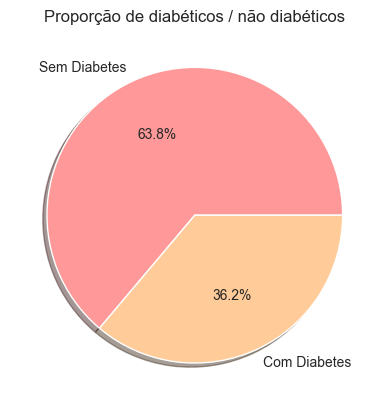

In [806]:
# Referência: https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
# Proporção de diabéticos / não diabéticos:
def getOutcomeDetails(data):
  plt.pie(
    data.Outcome.value_counts(),
    labels= ['Sem Diabetes', 'Com Diabetes'],
    autopct='%1.1f%%',
    shadow=True,
    colors = ['#ff9999','#ffcc99']
  );
  plt.title('Proporção de diabéticos / não diabéticos')
  plt.show()

getOutcomeDetails(dataWithoutOutliers);

In [807]:
# Função para substituir os valores vazios por média / ou mediana de uma determinada coluna:

def getMeanValue(dataFrame):
  return math.floor(dataFrame.mean());

def getMedianValue(dataFrame):
  return math.floor(dataFrame.median());

def getPartitionedData(column, outcome, delimiter = 0):
  df = pd.DataFrame({ 'data': column, 'label': outcome });
  filteredData = df[df['label'] == delimiter];
  return filteredData['data'];

def updateNaNColumn(df, columnName, type = 'mean'):
  negativeCases = getPartitionedData(df[columnName], df['Outcome'], 0);
  positiveCases = getPartitionedData(df[columnName], df['Outcome'], 1);

  # insert mean || median || 0 in NaN rows of positive cases:
  df.loc[
    df['Outcome'] == 1,
    columnName
  ] = df.loc[
    df['Outcome'] == 1,
    columnName
  ].fillna(
      getMeanValue(positiveCases) if (type == 'mean' or type == 'mean-median')
    else
      0
      if type == 'none'
    else
      getMedianValue(positiveCases)
    );

  # insert mean || median || 0 in NaN rows of negative cases:
  df.loc[
    df['Outcome'] == 0,
    columnName
  ] = df.loc[
    df['Outcome'] == 0,
    columnName
  ].fillna(
      getMeanValue(negativeCases) if type == 'mean'
    else
      0
      if type == 'none'
    else
      getMedianValue(negativeCases)
  ); 

In [808]:
updateNaNColumn(dataWithoutOutliers, 'SkinThickness', 'median');
updateNaNColumn(dataWithoutOutliers, 'BloodPressure', 'median');
updateNaNColumn(dataWithoutOutliers, 'Insulin', 'median');
# updateNaNColumn(dataWithoutOutliers, 'BMI', 'median');
# updateNaNColumn(dataWithoutOutliers, 'Glucose', 'mean');

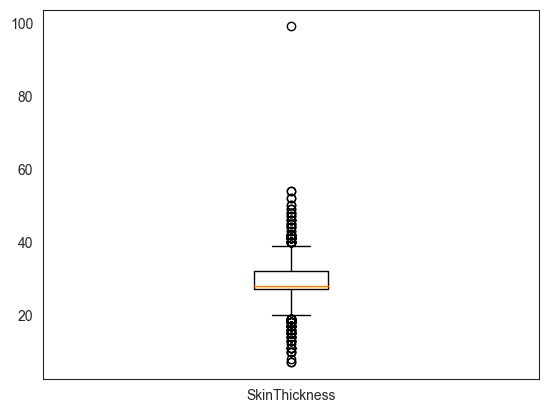

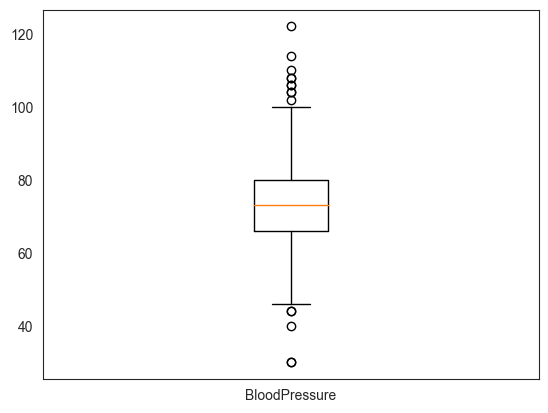

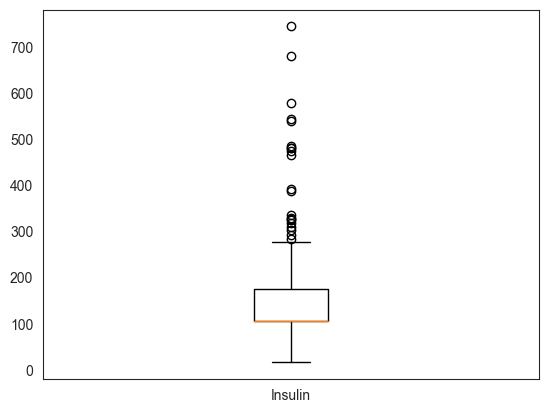

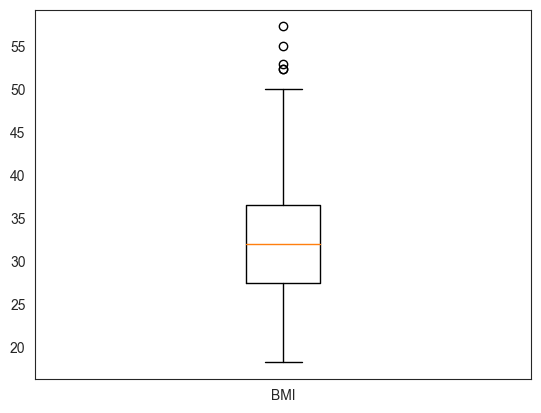

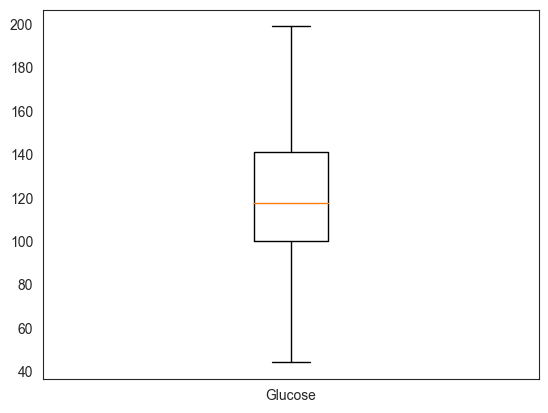

In [809]:
# BoxPlot para os dados completos:

plotBoxPlot(dataWithoutOutliers['SkinThickness'], ['SkinThickness']);
plotBoxPlot(dataWithoutOutliers['BloodPressure'], ['BloodPressure']);
plotBoxPlot(dataWithoutOutliers['Insulin'], ['Insulin']);
plotBoxPlot(dataWithoutOutliers['BMI'], ['BMI']);
plotBoxPlot(dataWithoutOutliers['Glucose'], ['Glucose']);

In [810]:
# dataWithoutOutliers = dropOutliers(dataWithoutOutliers, 'Insulin');
dataWithoutOutliers.info();


<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 0 to 571
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               556 non-null    int64  
 1   Glucose                   556 non-null    float64
 2   BloodPressure             556 non-null    float64
 3   SkinThickness             556 non-null    float64
 4   Insulin                   556 non-null    float64
 5   BMI                       556 non-null    float64
 6   DiabetesPedigreeFunction  556 non-null    float64
 7   Age                       556 non-null    int64  
 8   Outcome                   556 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 43.4 KB


In [811]:
# Códigos já fornecidos:

# Criando X and y par ao algorítmo de aprendizagem de máquina.\
print(' - Criando X e y para o algoritmo de aprendizagem a partir do arquivo diabetes_dataset');
# Caso queira modificar as colunas consideradas basta algera o array a seguir.
feature_cols = [
  'Pregnancies', 
  'Glucose', 
  'BloodPressure', 
  'SkinThickness', 
  'Insulin', 
  'BMI', 
  'DiabetesPedigreeFunction', 
  'Age'
];
X = dataWithoutOutliers[feature_cols];
y = dataWithoutOutliers.Outcome;

# Ciando o modelo preditivo para a base trabalhada
print(' - Criando modelo preditivo');
neigh = KNeighborsClassifier(n_neighbors=3);
neigh.fit(X, y);

#realizando previsões com o arquivo de
print(' - Aplicando modelo e enviando para o servidor');
data_app = pd.read_csv('diabetes_app.csv');
data_app = data_app[feature_cols];
y_pred = neigh.predict(data_app);

# Enviando previsões realizadas com o modelo para o servidor
URL = "https://aydanomachado.com/mlclass/01_Preprocessing.php";

# TODO Substituir pela sua chave aqui
DEV_KEY = "jst";

# json para ser enviado para o servidor
data = {
  'dev_key':DEV_KEY,
  'predictions':pd.Series(y_pred).to_json(orient='values')
};

# Enviando requisição e salvando o objeto resposta
r = requests.post(url = URL, data = data)

# Extraindo e imprimindo o texto da resposta
pastebin_url = r.text
print(" - Resposta do servidor:\n", r.text, "\n")


 - Criando X e y para o algoritmo de aprendizagem a partir do arquivo diabetes_dataset
 - Criando modelo preditivo
 - Aplicando modelo e enviando para o servidor
 - Resposta do servidor:
 {"error":{"code":102,"message":"Espere ao menos 10 minutos entre dois envios, tempo restante 00 dias 00 horas 13 minutos 37 segundos"}} 



Referências:

- https://medium.com/data-hackers/pr%C3%A9-processamento-de-dados-com-python-53b95bcf5ff4
- https://medium.com/horadecodar/como-tratar-dados-nulos-no-dataset-4f0470b22d38
- https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
- https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba